# 1. Introduction to `graph-tool`

The Python module __[`graph-tool`](https://graph-tool.skewed.de/)__, developed by Tiago Peixoto, is probably the best tool out there for probabilistic modeling of networks. Because it is written in C++, its efficiency is comparable to a pure C/C++ library. On the down side, some of its basic functionalities are a bit cumbersome compared to other Python modules for network analysis (for example, __[NetworkX](https://networkx.github.io/)__). Understanding this basic functionalities, however, is important for getting the most out of the module.

So let's take a look at the basics. Our goal here is to move quickly to network modeling with stochastic block models---for more details on other basic aspects, see the __[`graph-tool` tutorial](https://graph-tool.skewed.de/static/doc/quickstart.html)__.

First of all, we need to import the module: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import graph_tool as gt
from graph_tool.all import *

Great! We are now ready to start!

## 1.1. Creating graphs, nodes, and links 

To create an empty graph, we initialize an instance of the __[Graph](https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.Graph)__ class. Here, we will create an undirected graph:

In [3]:
g = Graph(directed=False)
print(g)

<Graph object, undirected, with 0 vertices and 0 edges at 0x7f3cf80517f0>


Now, we typically would want to add nodes and links to the network. The simplest way to do so is as follows:

In [4]:
v1 = g.add_vertex()
v2 = g.add_vertex()
e12 = g.add_edge(v1, v2)
print(g)

<Graph object, undirected, with 2 vertices and 1 edge at 0x7f3cf80517f0>


We can also add a bunch of nodes and a bunch of edges:

In [5]:
# Add 5 vertices
g.add_vertex(5)
# Add several links. Note that vertices can be accessed through their index using g.vertex(vertex_index)
g.add_edge_list([
    [g.vertex(0), g.vertex(4)],
    [g.vertex(0), g.vertex(6)],
    [g.vertex(4), g.vertex(5)],
    [g.vertex(1), g.vertex(6)],
])

Well, well, well---let's take a look at this network!

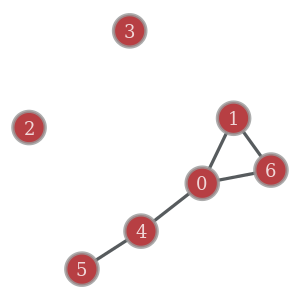

In [6]:
pos = graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=18, output_size=(300, 300))

## 1.2. Property maps 

So far, we have created graphs, nodes, and links, but we have not *map* information onto them, so that it is accessible. What if we want to add a label to nodes? How do we label the modules/community to which a given node belongs? What if our edges have weights? **Property maps** allow us to, precisely, associate additional information to nodes, links, and graphs. There are three types of property maps: vertex, edge, and graph property maps. All of them are handled by the same class, __[PropertyMap](https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.PropertyMap)__.

Property maps need to be created first, and are associated to a graph. Each created property map has an associated value type, which must be chosen from the predefined set---boolean, short integer, integer, string, double, and so on, as well as more general types such as vectors or even arbitraty Python objects.

Here is how it works:

In [7]:
vprop_double = g.new_vertex_property("double")            # Double-precision floating point
vprop_double[g.vertex(4)] = 3.1416

vprop_label = g.new_vertex_property("string")             # String
vprop_label[g.vertex(6)] = 'John'

vprop_vint = g.new_vertex_property("vector<int>")         # Vector of ints
vprop_vint[g.vertex(4)] = [1, 3, 42, 54]

eprop_dict = g.new_edge_property("object")                # Arbitrary python object.
eprop_dict[next(g.edges())] = {"foo": "bar", "gnu": 42}  # In this case, a dict.

For convenience, the whole collection of values of numeric property maps can be accessed, and changed, using the `.a` attribute.

In [8]:
print('Before:', vprop_double.a)
vprop_double.a = list(range(g.num_vertices()))   #change all at once
print('After: ', vprop_double.a)

Before: [ 0.      0.      0.      0.      3.1416  0.      0.    ]
After:  [ 0.  1.  2.  3.  4.  5.  6.]


For example, we may want to create a property map that contains the size of nodes. This is how we would do it:

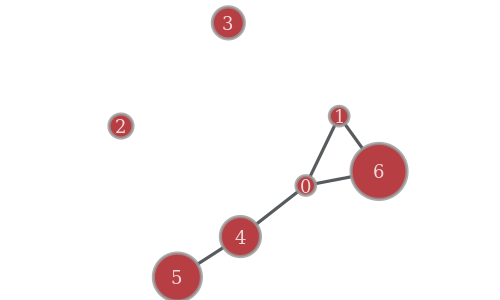

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f3cf80517f0, at 0x7f3cf8051b00>

In [10]:
vprop_size = g.new_vertex_property("int") 
vprop_size.a = [(i+1) * 8. for i in range(7)]
graph_draw(g, vertex_size=vprop_size, vertex_text=g.vertex_index, vertex_font_size=18, output_size=(500, 300), pos=pos)

### 1.2.1. Making property maps *internal* 

So far, property maps such as `vprop_size` are floating around in our code as independent variables. Often it is convenient to make these property maps "part of the graph", so that they can be accessed from within the graph itself. In `graph-tool`, this is achieved by making property maps *internal*. Internal property maps will be copied and saved with the graph.

Properties are internalized by including them in the graph's dictionary-like attributes `vertex_properties`, `edge_properties` or `graph_properties` (or their aliases `vp`, `ep`, and `gp`, respectively). When inserted in the graph, the property maps must be assigned a name. Here is how this works:

In [11]:
g.vp['size'] = vprop_size
g.list_properties()

print('\nSizes:', g.vp['size'].a)

size           (vertex)  (type: int32_t)

Sizes: [ 8 16 24 32 40 48 56]


Now, `size` is an internal vertex property of the graph. For convenience, internal property maps can also be accessed as attributes.

In [13]:
print('Node sizes:    ', g.vp.size.a)
print('Size of node 0:', g.vp.size[g.vertex(0)])

Node sizes:     [ 8 16 24 32 40 48 56]
Size of node 0: 8


## 1.3. Calculating basic properties of nodes, edges, and graphs 

Of course, we can use `graph-tool` to calculate basic properties of nodes, edges, and graphs. For example, we can compute the degree of a node as follows:

In [14]:
# Node degree (use out-degree for undirected graphs)
print('Degree of node 0:', g.vertex(0).out_degree())

Degree of node 0: 3


A faster alternative if you need to calculate node properties for many nodes in large networks is to use the __[array-based interface](https://graph-tool.skewed.de/static/doc/graph_tool.html#graph_tool.Graph.get_vertices)__ to the `Graph` class. 

In [15]:
# Get the degrees of all nodes in the network (faster than iterating over nodes in a regular Python loop)
print(g.get_out_degrees(g.get_vertices()))

[3 2 0 0 2 1 2]


However, most node properties (clustering, centrality, and so on) are given directly as property maps:

Node size according to local clustering


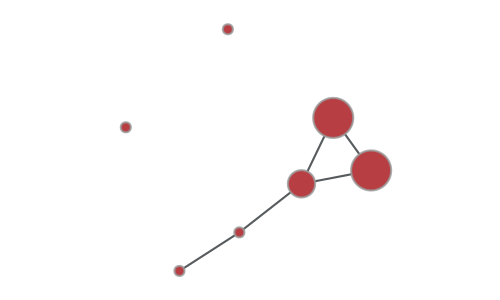

Node size according to betweenness


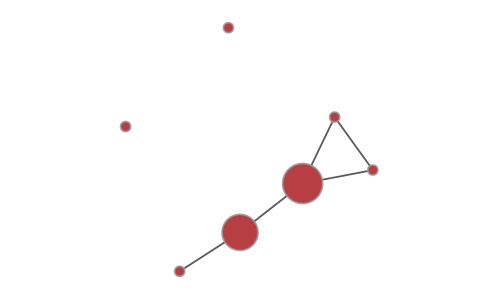

In [16]:
# Get local clustering and plot nodes according to this
g.vp['clustering'] = local_clustering(g)
# map clustering to reasonable node sizes
g.vp['size'] = prop_to_size(g.vp['clustering'], mi=10, ma=40)
# plot
print('Node size according to local clustering')
graph_draw(g, vertex_size=g.vp['size'], vertex_font_size=18, output_size=(500, 300), pos=pos)

# Get betweenness centrality and plot nodes according to this
g.vp['betweenness'] = g.new_vertex_property("double")
g.ep['betweenness'] = g.new_edge_property("double")
betweenness(g, vprop=g.vp['betweenness'], eprop=g.ep['betweenness'])
# map betweenness to reasonable node sizes
g.vp['size'] = prop_to_size(g.vp['betweenness'], mi=10, ma=40)
# plot
print('Node size according to betweenness')
graph_draw(g, vertex_size=g.vp['size'], vertex_font_size=18, output_size=(500, 300), pos=pos)
None

Averages over node properties can be obtained easily using the __[`vertex_average`](https://graph-tool.skewed.de/static/doc/stats.html#graph_tool.stats.vertex_average)__ function, which takes the graph and a property map as arguments:

In [17]:
print('Mean clustering: %g\t Std deviation: %g' % vertex_average(g, g.vp['clustering']))

Mean clustering: 0.333333	 Std deviation: 0.164957


### Exercise 1 - The Watts-Strogatz (small-world) model 

1. Create an undirected graph with 50 nodes, such that each node is connected to the two nodes immediately above and the two nodes immediately below so as to form a ring.
2. Calculate the average clustering coefficient and the average distance between nodes (hint: check the __[`shortest_distance`](https://graph-tool.skewed.de/static/doc/topology.html#graph_tool.topology.shortest_distance)__ function).
3. Add an edge between a randomly selected pair of nodes, and recalculate the clustering coefficient and the average path length.
4. Check what happens to the clustering and the average path length when you keep adding random links.

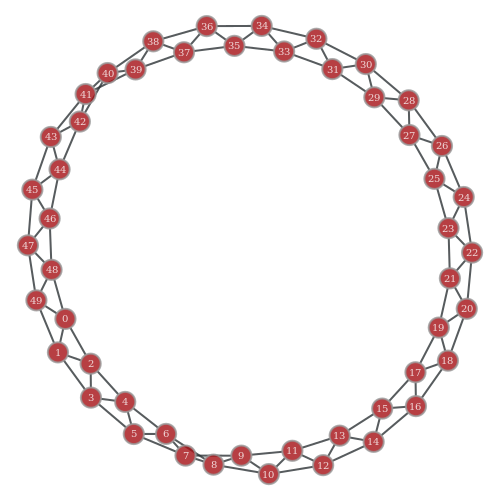

In [30]:
import numpy as np
# 1. Write your solution here
g = Graph(directed=False)
g.add_vertex(50)
vt_arr = np.arange(50)
edge_list = []
for vt_num in range(50):
    vt_up1 = vt_arr[vt_num-1]
    vt_up2 = vt_arr[vt_num-2]
#     print("Edges {} to {} and {}".format(vt_num, vt_up1, vt_up2))
    edge_list.append([g.vertex(vt_num), g.vertex(vt_up1)])
    edge_list.append([g.vertex(vt_num), g.vertex(vt_up2)])
g.add_edge_list(edge_list)
pos = graph_draw(g, vertex_text=g.vertex_index, 
                    vertex_font_size=10, 
                    output_size=(500, 500))

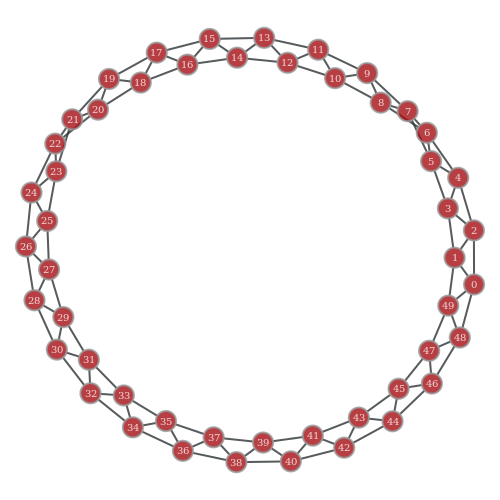

In [67]:
# 1. Write your solution here
g = Graph(directed=False)
g.add_vertex(50)
edge_list = []
for vt_num in range(50):
    vt_up1 = (vt_num+1) % 50
    vt_up2 = (vt_num+2) % 50
#     print("Edges {} to {} and {}".format(vt_num, vt_up1, vt_up2))
    edge_list.append([g.vertex(vt_num), g.vertex(vt_up1)])
    edge_list.append([g.vertex(vt_num), g.vertex(vt_up2)])
g.add_edge_list(edge_list)
pos = graph_draw(g, vertex_text=g.vertex_index, 
                    vertex_font_size=10, 
                    output_size=(500, 500))

In [73]:
def create_smallworld(num_nodes):
    g = Graph(directed=False)
    g.add_vertex(num_nodes)
    edge_list = []
    for vt_num in range(num_nodes):
        vt_up1 = (vt_num+1) % num_nodes
        vt_up2 = (vt_num+2) % num_nodes
    #     print("Edges {} to {} and {}".format(vt_num, vt_up1, vt_up2))
        edge_list.append([g.vertex(vt_num), g.vertex(vt_up1)])
        edge_list.append([g.vertex(vt_num), g.vertex(vt_up2)])
    g.add_edge_list(edge_list)
    return g

In [58]:
# 2. Write your solution here
# average clustering coefficient
g.vp['clustering'] = local_clustering(g)
g.vp['short_dist'] = shortest_distance(g)
print("Avg clustering {} +/- {}, Avg shortest distance {} +/- {:0.2f}"
     .format(vertex_average(g, g.vp['clustering'])[0],
             vertex_average(g, g.vp['clustering'])[1],
             np.mean(vertex_average(g, g.vp['short_dist'])[0]),
             np.sqrt(np.mean((vertex_average(g, g.vp['short_dist'])[1])**2))
            ))

Avg clustering 0.5 +/- 0.0, Avg shortest distance 6.5 +/- 0.51


In [65]:
def print_clustering_dist(g):
    g.vp['clustering'] = local_clustering(g)
    g.vp['short_dist'] = shortest_distance(g)
    print("Avg clustering {:0.3f} +/- {:0.3f}, Avg shortest distance {:0.3f} +/- {:0.3f}"
     .format(vertex_average(g, g.vp['clustering'])[0],
             vertex_average(g, g.vp['clustering'])[1],
             np.mean(vertex_average(g, g.vp['short_dist'])[0]),
             np.sqrt(np.mean((vertex_average(g, g.vp['short_dist'])[1])**2))
            ))

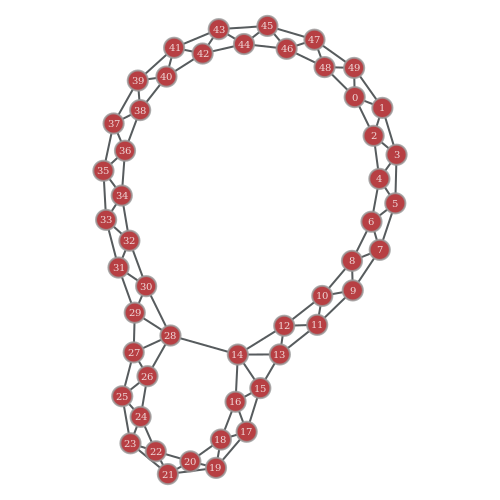

Avg clustering 0.492 +/- 0.006, Avg shortest distance 5.631 +/- 0.423


In [74]:
# 3. Write your solution here

g = create_smallworld(50)
# Add one random link
vt_rand1 = np.random.randint(50) % 50
vt_rand2 = np.random.randint(50) % 50
g.add_edge_list([[g.vertex(vt_rand1), g.vertex(vt_rand2)]])
pos = graph_draw(g, vertex_text=g.vertex_index, 
                    vertex_font_size=10, 
                    output_size=(500, 500))
print_clustering_dist(g)

Avg clustering 0.492 +/- 0.006, Avg shortest distance 5.468 +/- 0.404


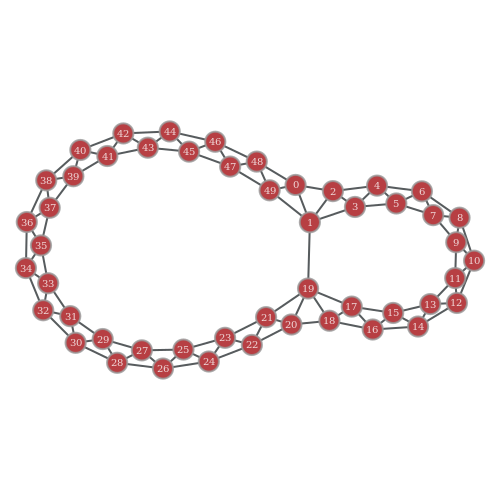

Avg clustering 0.495 +/- 0.008, Avg shortest distance 5.468 +/- 0.404
Avg clustering 0.432 +/- 0.017, Avg shortest distance 3.737 +/- 0.228


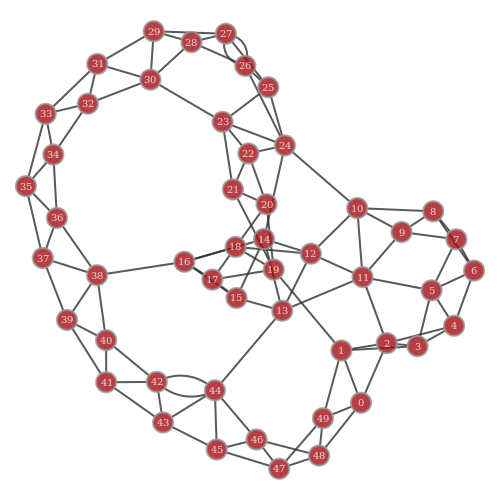

Avg clustering 0.395 +/- 0.018, Avg shortest distance 3.045 +/- 0.166


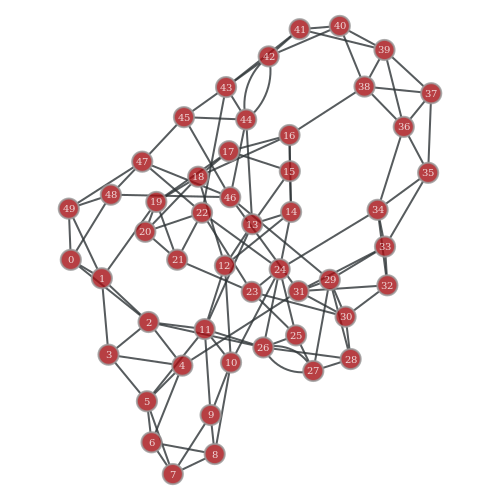

Avg clustering 0.357 +/- 0.016, Avg shortest distance 2.790 +/- 0.146


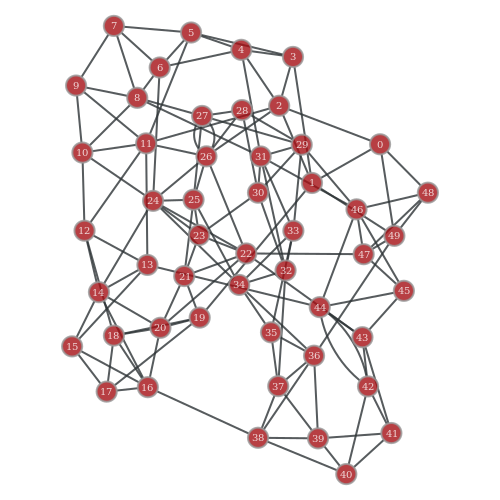

Avg clustering 0.319 +/- 0.016, Avg shortest distance 2.566 +/- 0.128


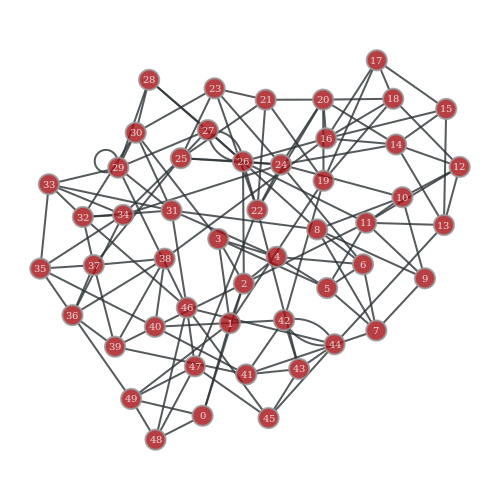

Avg clustering 0.300 +/- 0.017, Avg shortest distance 2.467 +/- 0.121


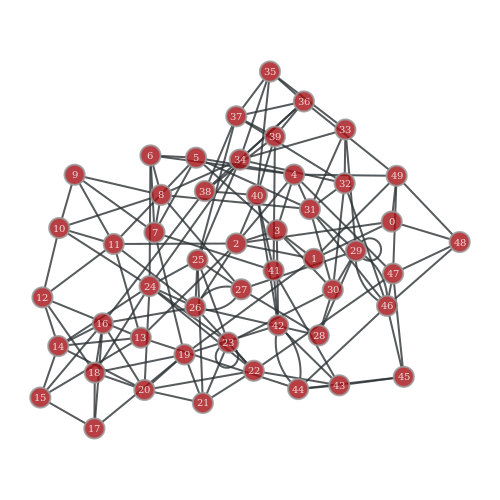

Avg clustering 0.299 +/- 0.017, Avg shortest distance 2.371 +/- 0.115


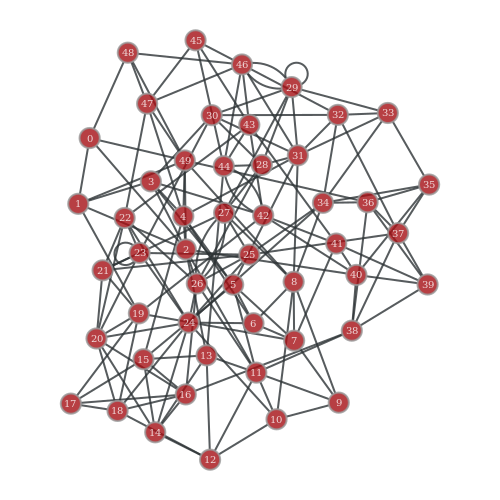

Avg clustering 0.271 +/- 0.015, Avg shortest distance 2.298 +/- 0.110


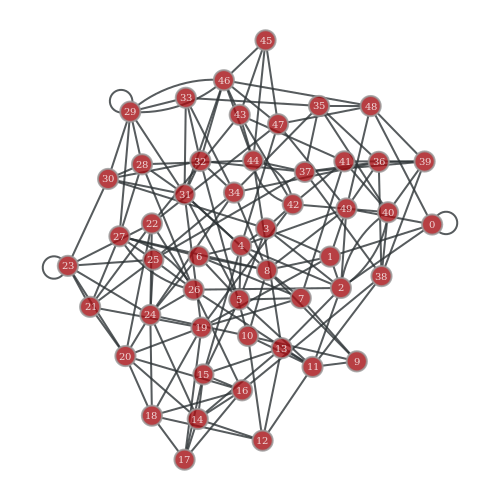

Avg clustering 0.255 +/- 0.012, Avg shortest distance 2.234 +/- 0.107


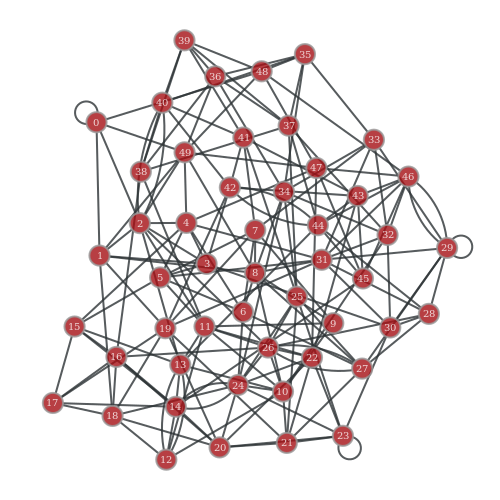

Avg clustering 0.249 +/- 0.012, Avg shortest distance 2.176 +/- 0.105


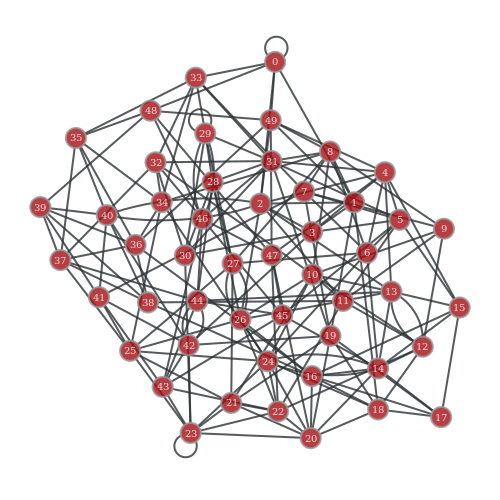

In [106]:
# 4. Write your solution here
g = create_smallworld(50)
# Add a bunch of random links
for run in range(100):
    vt_rand1 = np.random.randint(50) % 50
    vt_rand2 = np.random.randint(50) % 50
    g.add_edge_list([[g.vertex(vt_rand1), g.vertex(vt_rand2)]])
    
    if run == 1:
        print_clustering_dist(g)
    elif (run % 10) == 0:
        print_clustering_dist(g)
        pos = graph_draw(g, vertex_text=g.vertex_index, 
                            vertex_font_size=10, 
                            output_size=(500, 500))

# 2. Block modeling in `graph-tool` 

As mentioned above, `graph-tool` is most powerful at probabilistic modeling of networks and, in particular, at modeling with stochastic block models (SBM). The main concepts of probabilistic modeling and stochastic block models have been discussed in the previous lecture, so here we will focus on turning some of those concepts into code. For a complete tutorial, including a theoretical introduction (from a slightly different perspective than the lecture), you can take a look at __[this tutorial](https://graph-tool.skewed.de/static/doc/demos/inference/inference.html)__.

## 2.1. Finding the most plausible (MDL) partition

First, we focus on the problem of identifying the most plausible partition of the nodes in a network. As discussed in the lecture, the most plausible partition is the one with the shortest description length (or minimum description length, MDL), that is, the one that most compresses the data.

We will start by loading the College Football network:

The file football.gml contains the network of American football games
between Division IA colleges during regular season Fall 2000, as compiled
by M. Girvan and M. Newman.  The nodes have values that indicate to which
conferences they belong.  The values are as follows:

  0 = Atlantic Coast
  1 = Big East
  2 = Big Ten
  3 = Big Twelve
  4 = Conference USA
  5 = Independents
  6 = Mid-American
  7 = Mountain West
  8 = Pacific Ten
  9 = Southeastern
 10 = Sun Belt
 11 = Western Athletic

If you make use of these data, please cite M. Girvan and M. E. J. Newman,
Community structure in social and biological networks,
Proc. Natl. Acad. Sci. USA 99, 7821-7826 (2002).

Correction: Two edges were erroneously duplicated in this data set, and
have been removed (21 SEP 2014)



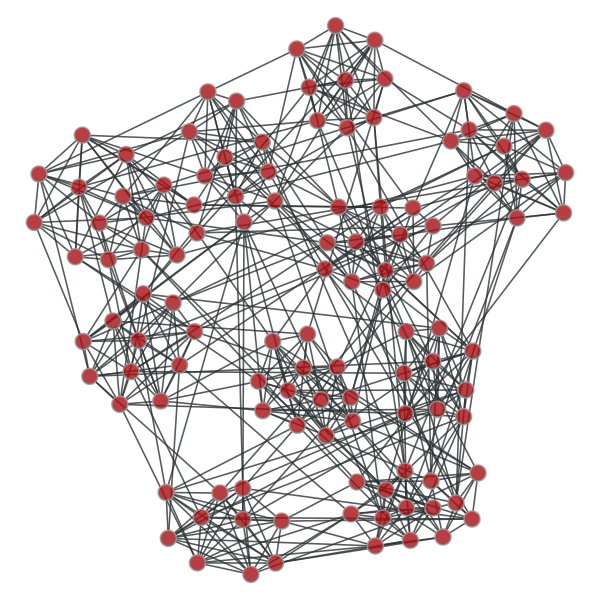

In [50]:
# Load the football network from the collection in graph_tool
gf = gt.collection.data['football']
print(gf.gp.readme)
graph_draw(gf, pos=gf.vp.pos)
None

Now, we will find the partition that minimizes the description length, and we will print the resulting description length. Note that the partition can be plotted directly using the `draw()` method of the __[`BlockState`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.blockmodel.BlockState)__ instance returned by __[`minimize_blockmodel_dl()`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.minimize.minimize_blockmodel_dl)__.

Description length: 1754.5145844121448


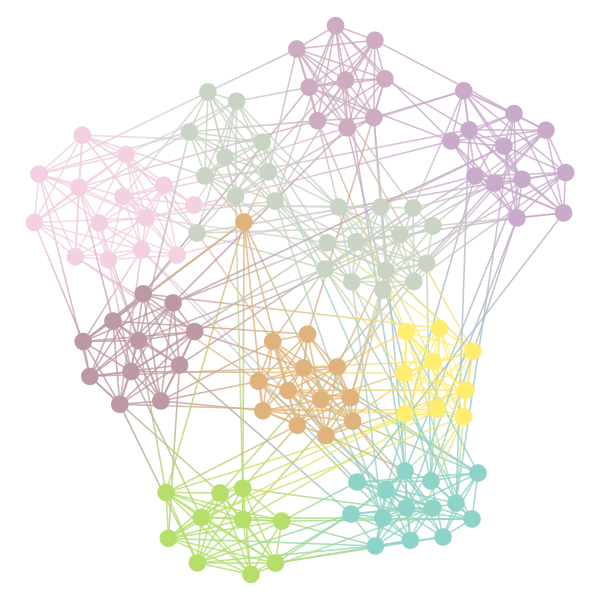

In [51]:
state = minimize_blockmodel_dl(gf, deg_corr=False)
print('Description length:', state.entropy())
state.draw(pos=gf.vp.pos)
None

When you run __[`minimize_blockmodel_dl()`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.minimize.minimize_blockmodel_dl)__, a bunch of things happen. First, nodes are assigned to some groups randomly. Then, group memberships are changed heuristically so as to minimize the description length. The process stops at what hopefully is---but typically is not---the shortest possible description length. Because this minimization process is heuristic and stochastic, there is no guarantee that two different runs will lead to the same solution. Therefore, in general it is a good idea to run it several times and keep the best (minimum description length) solution. This is what we do in the following code:

DL:  1752.7177914027168
DL:  1738.8687974848058
DL:  1750.068278535241
DL:  1738.8687974848058
DL:  1752.7177914027168
DL:  1761.7584450994407
DL:  1758.1546566417587
DL:  1754.3469560319386
DL:  1750.9327338935489
DL:  1754.5472155719804


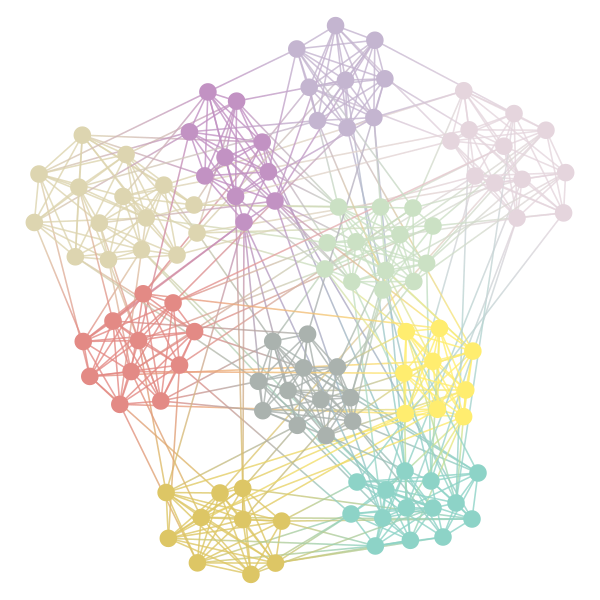


MDL: 1738.8687974848058


In [52]:
mdl_state, mdl = None, None
# Get 10 partitions and save the most plausible one (i.e. with minimum description length)
for i in range(10):
    state = gt.inference.minimize_blockmodel_dl(gf, deg_corr=False)
    dl = state.entropy()
    print('DL: ', dl)
    # Save the MDL block model
    if mdl_state == None or dl < mdl:
        mdl_state, mdl = state.copy(), dl
# Done
mdl_state.draw(pos=gf.vp.pos)
print('\nMDL:', mdl_state.entropy())

For a relatively small network like this one, and seeing all the values of the DL, we may be relatively confident that we have found the MDL solution. For larger networks, that is not the case. The heuristic used by `graph-tool`, however, does allow one to get good partitions for very large networks, with even millions of nodes.

One typically wants to analyze the groups in the optimal partition, as well as pattern of connections between those groups---`graph-tool` has some usefull functions for that. First, the block of each node can be obtained as follows:

In [78]:
b = mdl_state.get_blocks()
print(b[10])   # group membership of vertex 10

3


One can also easily plot the matrix of group-to-group connections:

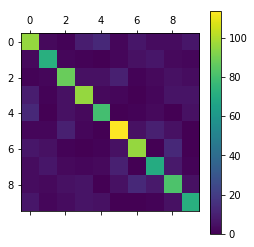

In [79]:
# Get the group-to-group connectivity matrix
e = mdl_state.get_matrix()
# Plot it as a matrix using standard matplotlib
plt.matshow(e.todense())
plt.colorbar()
plt.show()

Alternatively, one can obtain and represent the block graph, that is, the graph where each node represents a group in the orinal network, and the edges represent the connections between groups: 

count          (vertex)  (type: int32_t)
count          (edge)    (type: int32_t)


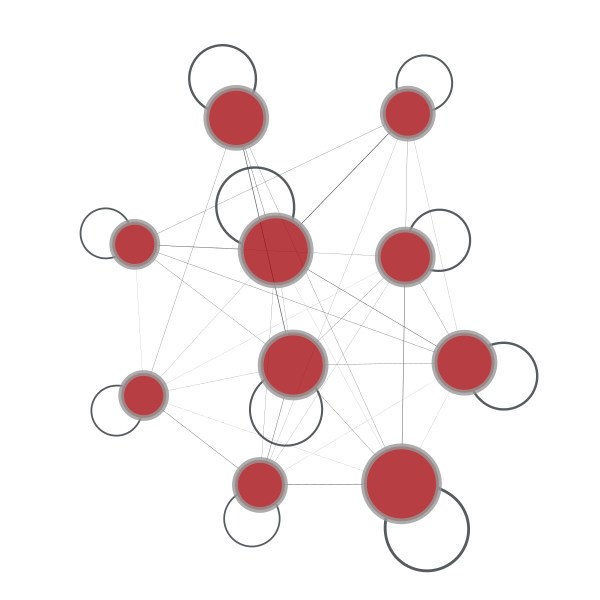

In [80]:
# Get the block graph and list the properties that are defined on nodes and links by default
bg = mdl_state.get_bg()

# Get the number of nodes in each group and of links between pairs of groups
bg.vp['count'] = mdl_state.get_nr()
bg.ep['count'] = mdl_state.get_ers()
bg.list_properties()

# Adjust the size of nodes and edges when plotting
s = prop_to_size(bg.vp.count, mi=min(bg.vp.count.a)*5, ma=max(bg.vp.count.a)*5, power=1)
w = prop_to_size(bg.ep.count, mi=min(bg.ep.count.a)*.05, ma=max(bg.ep.count.a)*.05, power=1)

# Draw
graph_draw(bg, vertex_size=s, edge_pen_width=w)
None

**Note** that in undirected networks, by convention, the diagonal elements of the `get_matrix()` matrix contain twice the number of within-group links. However `get_ers()` does not count the number of within-group links twice, so **be careful** when using either of these objects!

In [81]:
print('Using get_matrix:', mdl_state.get_matrix().todense()[0, 0])
print('Using get_bg:    ', mdl_state.get_bg().ep.count[bg.vertex(0), bg.vertex(0)])

Using get_matrix: 96.0
Using get_bg:     48


### Exercise 2 - Modeling a sparse Erdos-Renyi random graph

1. Create an undirected Erdos-Renyi random graph, that is, a graph in which each pair of nodes is connected with the same probability $p$. Use $N$=64 and $p$=0.02. Plot the graph and verify that you got a very sparse graph (in fact, the graph should consist of many isolated clusters).
2. Get the MDL partition. What partition did you get? Is it correct? Do you find this surprising?

In [97]:
# 1
num_nodes = 64
p = 0.02

edge_list = []
g = Graph(directed=False)
g.add_vertex(num_nodes)
for vt_i in range(num_nodes):
    for vt_j in range(num_nodes):
        if vt_i > vt_j:
            test = np.random.rand() 
            if test < p:
                edge_list.append([g.vertex(vt_i), g.vertex(vt_j)])
g.add_edge_list(edge_list)              

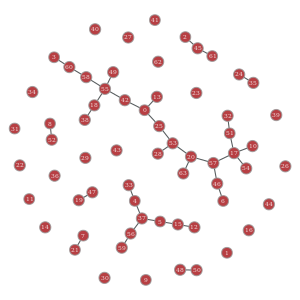

In [98]:
pos = graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=6, output_size=(300, 300))

Description length: 182.92547204295477


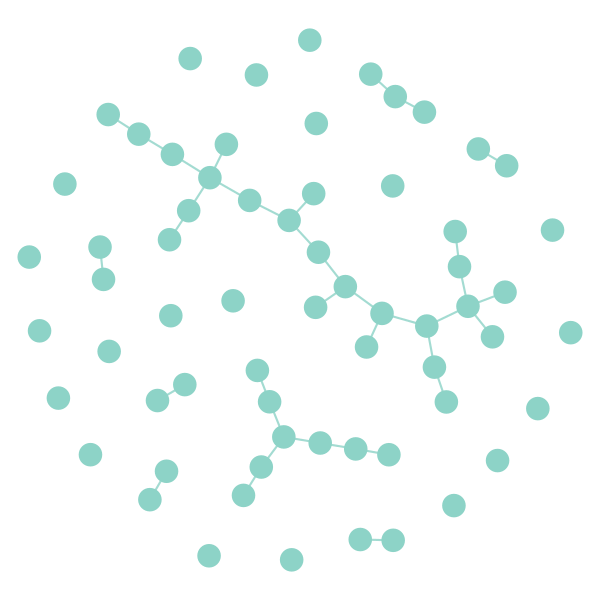

In [99]:
state = minimize_blockmodel_dl(g, deg_corr=False)
print('Description length:', state.entropy())
state.draw(pos=pos)
None

DL:  182.92547204295477
DL:  182.92547204295477
DL:  182.92547204295477
DL:  182.92547204295477
DL:  182.92547204295477


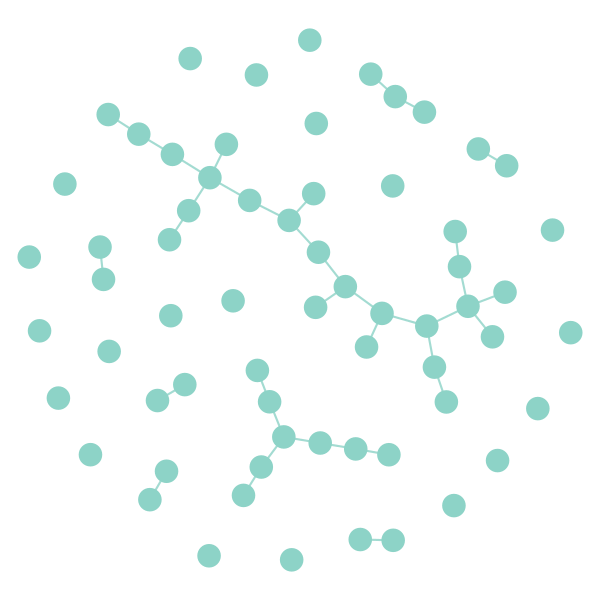


MDL: 182.92547204295477


In [102]:
# 2
# block modeling
mdl_state, mdl = None, None
# Get 10 partitions and save the most plausible one (i.e. with minimum description length)
for i in range(5):
    state = minimize_blockmodel_dl(g, deg_corr=False)
    dl = state.entropy()
    print('DL: ', dl)
    # Save the MDL block model
    if mdl_state == None or dl < mdl:
        mdl_state, mdl = state.copy(), dl
# Done
mdl_state.draw(pos=pos)
print('\nMDL:', mdl_state.entropy())

## 2.2. Optimal partition using hierarchical priors on the partitions

So far, we have assumed that all partitions of the nodes are equally likely a priori. In real life, however, it is not clear whether this is a good assumption, or whether we could actually use some additional information to prefer some partitions over others. But what? What can we say a priori, and in general, about the groups?

One think that we can say is that the groups are not randomly organized themselves. Rather it is plausible that groups are organized into larger groups-of-groups, and those into groups-of-groups-of-groups, and so on. Indeed, the idea that node groups in networks are hierarchically organized has a relatively long history in network science [__[Sales-Pardo et. al., 2007](http://www.pnas.org/content/104/39/15224)__].

`graph-tool` allows you to use such hierarchical priors for the partitions---instead of using __[`minimize_blockmodel_dl()`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.minimize.minimize_blockmodel_dl)__ you just need to use __[`minimize_nested_blockmodel_dl()`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.minimize.minimize_nested_blockmodel_dl)__.

DL:  1746.1778545534435
DL:  1745.0069340574094
DL:  1733.5256851451725
DL:  1735.8953034465699
DL:  1733.5256851451725

MDL: 1733.5256851451725


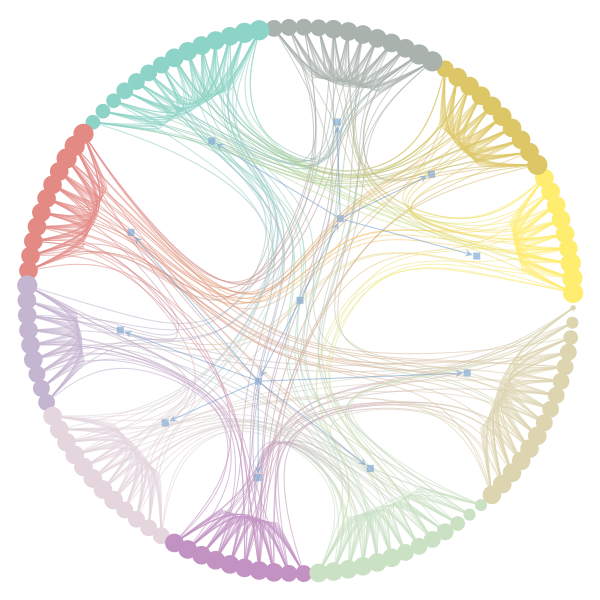

In [103]:
mdl_state, mdl = None, None
for i in range(5):
    state = minimize_nested_blockmodel_dl(gf, deg_corr=False)
    dl = state.entropy()
    print('DL: ', dl)
    if mdl_state == None or dl < mdl:
        mdl_state, mdl = state.copy(), dl
        
# Done
print('\nMDL:', mdl_state.entropy())
mdl_state.draw()
None

So we get a hierarchy with two levels---one separating two big groups, and the second one with each of the leagues in a different group.

The partition at the lowest level looks like this:

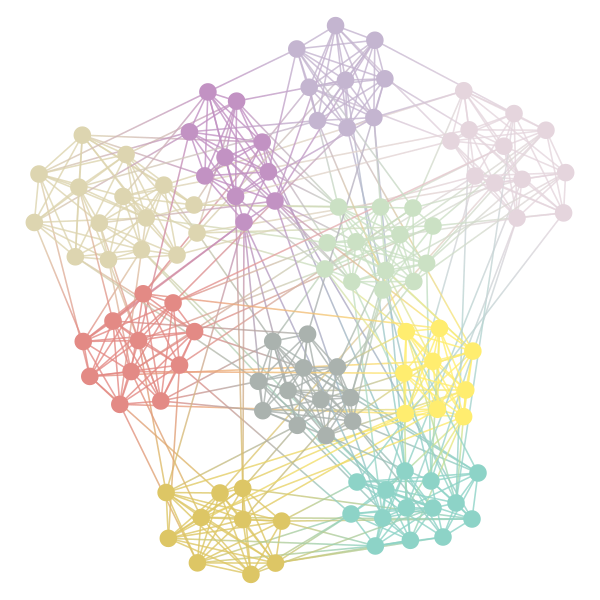

In [104]:
# Get the lowest-level partition in the hierarchy and plot it
mdl_state.levels[0].draw(pos=gf.vp.pos)
None

But, is this hierarchical model a better model than the flat model we got before, with the flat prior on partitions? Remember that the MDL we got before was 1738.9. Since the hierarchical model gives MDL 1733.5, we must conclude that the most plausible hierarchical model is more plausible than the most plausible non-hierarchical model. 

### Exercise 3. Hierarchical SBM on the sparse ER graph 

1. Get the optimal partition for the ER graph of Exercise 2 using hierarchical priors.
2. Is the MDL partition different? What about the DL?

In [ ]:
#1

## 2.3. Degree-corrected stochastic block model

One caveat of the stochastic block model that we haven't discussed so far is that all nodes in the same group must have similar degree. To be more precise, since all nodes in the same group have the exact same probabilities of connecting to other nodes in the network, the degree distribution of nodes in the same group is Poisson. This feature is, in some cases, unrealistic.

To address this issue, Karrer and Newman introduced a degree-corrected version of the stochastic block model [__[Karrer & Newman, 2011]()__]. In this model, the probability of connection of each node is modulated by a node-specific factor, so that even nodes in the same group can have very different degrees (although their overall pattern of connection will still be the same).

Usign the degree-corrected SBM instead of the regular SBM in `graph-tool` is straightforward---we just need to specify `deg_corr=True` when calling __[`minimize_blockmodel_dl()`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.minimize.minimize_blockmodel_dl)__ or __[`minimize_nested_blockmodel_dl()`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.minimize.minimize_nested_blockmodel_dl)__. 

### Exercise 4. Degree-corrected SBM of the sparse ER graph

1. Get the optimal partition for the ER graph of Exercise 2 using the degree-corrected stochastic block model.
2. Is the MDL partition different? What about the DL? Smaller? Larger?

In [ ]:
# 1

# 3. Sampling over the space of partitions

As discussed in the lecture, the most plausible (or MDL) partition of the nodes provides only a partial view of the organization of the network (just as in the example with the coins!). For some analyses (e.g. link prediction) it is more appropriate not to focus on a single partition, but rather sample over the whole space of plausible partitions.

This is achieved using Markov chain Monte Carlo (MCMC). MCMC generates a sequence (chain) of partitions such that the frequency with which a partition appears in the sequence is proportional to its plausibility.

The basic method for MCMC sampling of partitions in `graph-tool` is __[`mcmc_sweep()`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.blockmodel.BlockState.mcmc_sweep)__, which is a method of the __[`BlockState`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.blockmodel.BlockState)__ class. Given a partition, `mcmc_sweep()` modifies it using MCMC to attempt, and eventually accept, random moves of nodes from one group to another. Let's see how this works on the football network (the same can be done in the case of hierarchical priors, with the only difference that the __[`NestedBlockState`](https://graph-tool.skewed.de/static/doc/inference.html#graph_tool.inference.nested_blockmodel.NestedBlockState)__ needs to be initialized with `sampling=True`):

In [ ]:
# Get a partition and plot it
state = minimize_blockmodel_dl(gf, deg_corr=False)
print('DL before:', state.entropy())
state.draw(pos=gf.vp.pos, output_size=(200,200))

# Modify the partition (100 MCMC steps) and plot it again
state.mcmc_sweep(niter=100)
print('DL after:', state.entropy())
state.draw(pos=gf.vp.pos, output_size=(200,200))

None

Typically, one wants to sample over partitions to estimate the probability of certain statements. For example, in the MDL partition of this network, two schools may belong to the same group. But that does not *guarantee* that the two schools are actually in the same group, because there is no guarantee that the MDL partition is the true partition that generated the data. Therefore, the most complete approach possible to answer the question *"Are schools A and B in the same group"* is to sample over the space of partitions using MCMC and count how often that A and B are in the same group in the sampled partitions.

Let's recall what the football network looks like:

In [ ]:
graph_draw(gf, pos=gf.vp.pos, vertex_text=gf.vertex_index, output_size=(400, 400))
print(gf.gp.readme)

And now, let's sample over partitions and see what is the probability that certain pairs of schools are actually in the same group.

In [ ]:
# First we need to burn-in (a.k.a. thermalize or equilibrate) the MCMC so that
# we are really sampling from the posterior distribution
state = BlockState(gf, B=gf.num_vertices(), deg_corr=False)
dls = []
for rep in range(5000):
    state.mcmc_sweep(niter=1)
    dls.append(state.entropy())

# Which pairs of schools we want to check?
PAIRS = [
    (29, 79),
    (29, 36),
    (36, 12),
    (12, 99),
]

# For each pair of schools, sample some partitions and see if the schools are together
for n1, n2 in PAIRS:
    ntogether, ntot = 0, 0
    for rep in range(1000):
        state.mcmc_sweep(niter=5)
        b = state.get_blocks()
        if b[n1] == b[n2]:
            ntogether += 1
        ntot += 1
    print('Probability that %s (%d) and %s (%d) are in the same group:' % (gf.vp.label[n1],
                                                                           gf.vp.value[n1],
                                                                           gf.vp.label[n2],
                                                                           gf.vp.value[n2]), float(ntogether) / ntot)

Of course, one could use sampling to answer any kind of network-related question: What is the probability that two nodes are connected? What is the probability that the clustering coefficient of the network is between 0.1 and 0.2? Anything!

### Final exercise: Modeling and prediction for the North American air transportation network 

The aim of this final exercise is to combine all the concepts discussed above to analyze the network of flight connections between cities in North America (or, more precisely, in the U.S. and Canada) [__[Guimera, Mossa, Turtschi, Amaral, 2005](http://dx.doi.org/10.1073/pnas.0407994102)__]. Here is the network:

In [ ]:
air = load_graph('data/na_airports.xml.gz')
graph_draw(air, pos=air.vp.pos, output_size=(900, 500))
None

1. **MDL model.** Model the network using the SBM with and without degree correction, and with and without hierarchical priors on the partitions. Which model is best?

2. **Link prediction.** Compare different approaches (especially, single point estimate versus sampling) to link prediction:

    2.1. Remove 10 randomly-chosen links from the network. We call the network with links removed the *observed network*. 
    
    2.2. Get the MDL model for the observed network, and use this MDL model to predict the probability of all non-links in the network, including true negatives (links that did not exist in the original network) and false negatives (links that existed in the original networks but that are missing in the observed network). Calculate the AUC of the prediction, that is, the probability that a false negative is assigned a higher probability of existing than a true negative.
    
    2.3. Now use sampling to predict the probability of existence of all non-links. Again, calculate the AUC of the prediction.
    
    2.4. Which method gave the highest AUC? You can repeat 2.1.-2.4. several times to obtain better estimates of the differences, as well as confidence intervals.

In [ ]:
# 1

In [ ]:
# 2.1

In [ ]:
# 2.2

In [ ]:
# 2.3